<a href="https://colab.research.google.com/github/gaurav1030332018/cancerdetection/blob/main/tumorvgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
import os
import cv2

In [3]:
IMAGE_SIZE = [224, 224]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [6]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/kaggle dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
    #  print(j)
      try:
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
      except Exception as e:
        pass

        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/kaggle dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
#X_train.shape
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:13<00:00,  5.59it/s]


In [8]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train.shape

(3263, 224, 224, 3)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [11]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
model = vgg.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=vgg.input, outputs = model)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [12]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [13]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("vgg.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)#it will save best model only
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [14]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =30, verbose=1, batch_size=16,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/30
166/166 [==============================] - ETA: 0s - loss: 1.8704 - accuracy: 0.2922
Epoch 00001: val_accuracy improved from -inf to 0.31633, saving model to vgg.h5
166/166 [==============================] - 95s 459ms/step - loss: 1.8704 - accuracy: 0.2922 - val_loss: 1.5509 - val_accuracy: 0.3163 - lr: 0.0010
Epoch 2/30
166/166 [==============================] - ETA: 0s - loss: 1.3335 - accuracy: 0.3304
Epoch 00002: val_accuracy improved from 0.31633 to 0.32993, saving model to vgg.h5
166/166 [==============================] - 71s 426ms/step - loss: 1.3335 - accuracy: 0.3304 - val_loss: 1.2855 - val_accuracy: 0.3299 - lr: 0.0010
Epoch 3/30
166/166 [==============================] - ETA: 0s - loss: 1.2200 - accuracy: 0.4235
Epoch 00003: val_accuracy improved from 0.32993 to 0.52041, saving model to vgg.h5
166/166 [==============================] - 70s 425ms/step - loss: 1.2200 - accuracy: 0.4235 - val_loss: 1.1454 - val_accuracy: 0.5204 - lr: 0.0010
Epoch 4/30
166/166 [=====

In [15]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1) #preidcted values
y_test_new = np.argmax(y_test,axis=1) #original values

In [16]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85        95
           1       0.73      0.85      0.78        47
           2       0.79      0.76      0.78        96
           3       0.90      0.97      0.93        89

    accuracy                           0.84       327
   macro avg       0.83      0.84      0.83       327
weighted avg       0.84      0.84      0.84       327



NameError: ignored

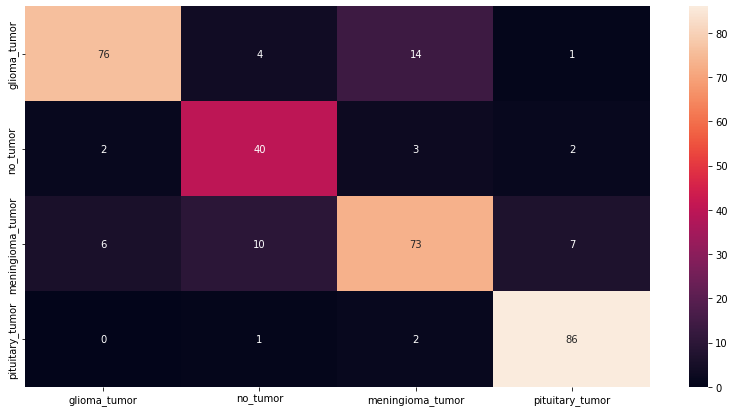

In [19]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
           #cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
#from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output

In [20]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [21]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [22]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

In [23]:
import pickle

In [27]:
pickle.dump(model, open('vvgg16.sav', 'wb'))


INFO:tensorflow:Assets written to: ram://69f1fdf8-03d3-4236-b165-ef1b133d2030/assets
